# Importance sampling

In [2]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [7]:

""" 
IMPORTS
"""
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
import pickle
import pandas as pd
from one.api import ONE
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from scipy import stats
from scipy.fftpack import fft, ifft, fftshift

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log

one = ONE(mode='remote')

In [8]:
# LOAD DATA
bin_size = 0.017

data_path =prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v6_21Jul2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)


# Wavelet decomposition
f = np.array([.25, .5, 1, 2, 4, 8, 16])
omega0 = 5

# Subsample and embedd 

In [9]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    sessions_to_process.append((mouse_name, session))

In [76]:
from joblib import Parallel, delayed


def morlet_conj_ft(omega_vals, omega0):
    """
    Computes the conjugate Fourier transform of the Morlet wavelet.
    
    Parameters:
    - w: Angular frequency values (array or scalar)
    - omega0: Dimensionless Morlet wavelet parameter
    
    Returns:
    - out: Conjugate Fourier transform of the Morlet wavelet
    """
    
    return np.pi**(-1/4) * np.exp(-0.5 * (omega_vals - omega0)**2)


def fast_wavelet_morlet_convolution_parallel(x, f, omega0, dt):
    """
    Fast Morlet wavelet transform using parallel computation.

    Args:
        x (array): 1D array of projection values to transform.
        f (array): Center frequencies of the wavelet frequency channels (Hz).
        omega0 (float): Dimensionless Morlet wavelet parameter.
        dt (float): Sampling time (seconds).

    Returns:
        amp (array): Wavelet amplitudes.
        W (array): Wavelet coefficients (complex-valued, optional).
    """
    N = len(x)
    L = len(f)
    amp = np.zeros((L, N))
    Q = np.zeros((L, N))

    # Ensure N is even
    if N % 2 == 1:
        x = np.append(x, 0)
        N += 1
        test = True
    else:
        test = False

    # Add zero padding to x
    # Zero padding serves to compensate for the fact that the kernel does not have the same size as 
    # 
    x = np.concatenate((np.zeros(N // 2), x, np.zeros(N // 2)))
    M = N
    N = len(x)

    # Compute scales
    scales = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * f)
    # angular frequencies to compute FT for (depends on sampling frequency); is as long as N 
    omega_vals = 2 * np.pi * np.arange(-N // 2, N // 2) / (N * dt)  

    # Fourier transform of x; shift folds it around zero so that it is more interpretable (frequencies at the right of nyquist become negative)
    x_hat = fftshift(fft(x))

    # Index for truncation to recover the actual x without padding
    if test:
        idx = np.arange(M // 2, M // 2 + M - 1)
    else:
        idx = np.arange(M // 2, M // 2 + M)

    # Function for parallel processing
    def process_frequency(i):
        # Take the Morlet conjugate of the Fourier transform
        m = morlet_conj_ft(-omega_vals * scales[i], omega0)
        # Convolution on the Fourier domain (as opposed to time domain in DWT)
        conv = m * x_hat
        # Inverse Fourier transform (normalized?)
        # q are the wavelet coefficients; normalized to ensure the energy of the wavelet is preserved across different scales
        q = ifft(conv) * np.sqrt(scales[i])
        # Recover q without padding
        q = q[idx]
        amp_row = np.abs(q) * np.pi**-0.25 * np.exp(0.25 * (omega0 - np.sqrt(omega0**2 + 2))**2) / np.sqrt(2 * scales[i])
        return amp_row, q

    # Parallel processing
    results = Parallel(n_jobs=-1)(delayed(process_frequency)(i) for i in range(L))

    for i, (amp_row, q) in enumerate(results):
        amp[i, :] = amp_row
        Q[i, :] = q

    return amp, Q, x_hat


def plot_kde(X_embedded, kernel):
    xmin = -150
    xmax = 150
    ymin=-150
    ymax=150
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(positions).T, X.shape)

    fig, ax = plt.subplots()
    ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
            extent=[xmin, xmax, ymin, ymax])
    ax.plot(X_embedded[:, 0], X_embedded[:, 1], 'k.', markersize=2)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    plt.show()


In [133]:
concatenated_subsampled = np.array([])

paw_vars = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y']

var_interest = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 
                'l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']

for m, mat in enumerate(sessions_to_process):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)
    
    for v, var in enumerate(paw_vars):
        
        var_array = np.array(design_matrix[var])
        not_nan = ~np.isnan(var_array)
        clean_array = np.array(stats.zscore(design_matrix[var][not_nan]))
        # Wavelet decomposition of wheel velocity
        dt = np.round(np.mean(np.diff(design_matrix['Bin'])), 3)
        amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(clean_array, f, omega0, dt)

        # Wavelet transforms
        for i, frequency in enumerate(f):
            # Create new column with frequency
            design_matrix[str(var+str(frequency))] = design_matrix['Bin'] * np.nan
            design_matrix[str(var+str(frequency))] = np.nan
            design_matrix[str(var+str(frequency))][not_nan] = amp[i, :]

            
    # plt.bar(x=design_matrix.mean().keys()[15:], height = design_matrix.mean()[15:])
    # plt.show()
    

    # Prepare data
    data_df = design_matrix[var_interest].copy().dropna()
    data_df[paw_vars] = stats.zscore(np.array(data_df[paw_vars]), axis=0)  #stats.zscore(data_df[paw_vars], axis=0)
    
    # data = np.array(design_matrix[var_interest].copy().dropna())
    data = np.array(data_df)
    
    """ Randomly subsample """
    n_samples = 20000
    sampled_indices = np.random.choice(data.shape[0], 
                                       n_samples, 
                                       replace=False)
    sampled_data = data[sampled_indices, :]
    
    """ Perform t-SNE """
    X = sampled_data.copy()
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=32).fit_transform(X)
    # plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.02)
    # plt.show()
    
    """ Perform Gaussian kde """
    values = X_embedded.T.copy()
    kernel = stats.gaussian_kde(values)
    # plot_kde(X_embedded, kernel)
    
    """ Resample weighted by kde estimate """
    sample_prob = kernel(values)
    norm_sample_prob = sample_prob/ np.sum(sample_prob)
    resampled_indices = np.random.choice(sampled_data.shape[0], 
                                    size=2000, 
                                    p=norm_sample_prob, replace=False)
    resampled_data = sampled_data[resampled_indices, :]
    
    """ Concatenate session """
    if len(concatenated_subsampled) == 0:
        concatenated_subsampled = resampled_data.copy()
    else:
        concatenated_subsampled = np.vstack([concatenated_subsampled, resampled_data])
    
    print(mat)

/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('CSH_ZAD_026', '15763234-d21e-491f-a01b-1238eb96d389')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NR_0027', 'ae8787b1-4229-4d56-b0c2-566b61a25b77')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('PL033', 'a34b4013-414b-42ed-9318-e93fbbc71e7b')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('ibl_witten_29', '821f1883-27f3-411d-afd3-fb8241bbc39a')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-47', 'fc43390d-457e-463a-9fd4-b94a0a8b48f5')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('PL033', '49250fba-801c-4867-a0a7-a1e19538cb61')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NR_0027', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('ibl_witten_32', '08102cfc-a040-4bcf-b63c-faa0f4914a6f')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('PL033', '2ab7d2c2-bcb7-4ae6-9626-f3786c22d970')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is 

('ibl_witten_29', 'd2832a38-27f6-452d-91d6-af72d794136c')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NR_0020', '5b49aca6-a6f4-4075-931a-617ad64c219c')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('CSH_ZAD_029', '5522ac4b-0e41-4c53-836a-aaa17e82b9eb')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('ibl_witten_27', '73918ae1-e4fd-4c18-b132-00cb555b1ad2')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('ibl_witten_26', 'a9138924-4395-4981-83d1-530f6ff7c8fc')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('NYU-40', 'f359281f-6941-4bfd-90d4-940be22ed3c3')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('ibl_witten_29', '58b1e920-cfc8-467e-b28b-7654a55d0977')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('NR_0027', '0f77ca5d-73c2-45bd-aa4c-4c5ed275dbde')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('CSH_ZAD_026', '626126d5-eecf-4e9b-900e-ec29a17ece07')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('ibl_witten_27', 'f304211a-81b1-446f-a435-25e589fe3a5a')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('NR_0021', '1ca83b26-30fc-4350-a616-c38b7d00d240')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-30', '77e6dc6a-66ed-433c-b1a2-778c914f523c')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-40', '5157810e-0fff-4bcf-b19d-32d4e39c7dfc')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-47', '288bfbf3-3700-4abe-b6e4-130b5c541e61')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('CSH_ZAD_029', 'fcd49e34-f07b-441c-b2ac-cb8c462ec5ac')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is 

('CSH_ZAD_029', '993c7024-0abc-4028-ad30-d397ad55b084')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-39', '35ed605c-1a1a-47b1-86ff-2b56144f55af')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('ibl_witten_29', 'af55d16f-0e31-4073-bdb5-26da54914aa2')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-45', '51e53aff-1d5d-4182-a684-aba783d50ae5')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-21', 'ebe2efe3-e8a1-451a-8947-76ef42427cc9')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('ibl_witten_29', '86b6ba67-c1db-4333-add0-f8105ea6e363')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('ibl_witten_27', '952870e5-f2a7-4518-9e6d-71585460f6fe')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('CSH_ZAD_019', '7f6b86f9-879a-4ea2-8531-294a221af5d0')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is 

('NYU-39', '91a3353a-2da1-420d-8c7c-fad2fedfdd18')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('ibl_witten_26', 'dc21e80d-97d7-44ca-a729-a8e3f9b14305')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('NYU-39', '6ed57216-498d-48a6-b48b-a243a34710ea')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-46', '6434f2f5-6bce-42b8-8563-d93d493613a2')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-46', '72982282-e493-45ee-87ce-aa45cb3a3ec1')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('NR_0021', '27ef44c0-acb2-4220-b776-477d0d5abd35')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NR_0021', 'e0928e11-2b86-4387-a203-80c77fab5d52')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('ibl_witten_18', 'cae5cd75-55e5-4277-8db3-cf4d6c5ff918')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('CSH_ZAD_026', '81a78eac-9d36-4f90-a73a-7eb3ad7f770b')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NR_0020', 'd901aff5-2250-467a-b4a1-0cb9729df9e2')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('NR_0020', '3e6a97d3-3991-49e2-b346-6948cb4580fb')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('ibl_witten_26', 'ff96bfe1-d925-4553-94b5-bf8297adf259')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('ibl_witten_26', '09394481-8dd2-4d5c-9327-f2753ede92d7')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('ibl_witten_29', '69a0e953-a643-4f0e-bb26-dc65af3ea7d7')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('ibl_witten_29', '0cc486c3-8c7b-494d-aa04-b70e2690bcba')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('CSH_ZAD_019', '5adab0b7-dfd0-467d-b09d-43cb7ca5d59c')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('ibl_witten_20', '037d75ca-c90a-43f2-aca6-e86611916779')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is 

('NYU-39', 'fa1f26a1-eb49-4b24-917e-19f02a18ac61')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('NYU-45', '537677fe-1e24-4755-948c-fa4a4e8ecce5')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('ibl_witten_29', '72028382-a869-4745-bacf-cb8789e16953')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NR_0020', 'eacc49a9-f3a1-49f1-b87f-0972f90ee837')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('ibl_witten_29', 'e9fc0a2d-c69d-44d1-9fa3-314782387cae')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-46', '64e3fb86-928c-4079-865c-b364205b502e')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NR_0027', '195443eb-08e9-4a18-a7e1-d105b2ce1429')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('NYU-40', '71855308-7e54-41d7-a7a4-b042e78e3b4f')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('NYU-45', '5bcafa14-71cb-42fa-8265-ce5cda1b89e0')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('ibl_witten_25', '5285c561-80da-4563-8694-739da92e5dd0')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('CSH_ZAD_026', 'b69b86be-af7d-4ecf-8cbf-0cd356afa1bd')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('NYU-30', '5ec72172-3901-4771-8777-6e9490ca51fc')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values

('NYU-46', 'd32876dd-8303-4720-8e7e-20678dc2fd71')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-40', '8ca740c5-e7fe-430a-aa10-e74e9c3cbbe8')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-39', 'ee212778-3903-4f5b-ac4b-a72f22debf03')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('PL033', '94dabed1-741c-4ddd-a6b7-70561e27b750')


/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[str(var+str(frequ

('NYU-47', '15948667-747b-4702-9d53-354ac70e9119')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('CSH_ZAD_029', 'fece187f-b47f-4870-a1d6-619afe942a7d')


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/tmp/ipykernel_18324/728383092.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_18324/12507904.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in 

('NYU-30', '5569f363-0934-464e-9a5b-77c8e67791a1')


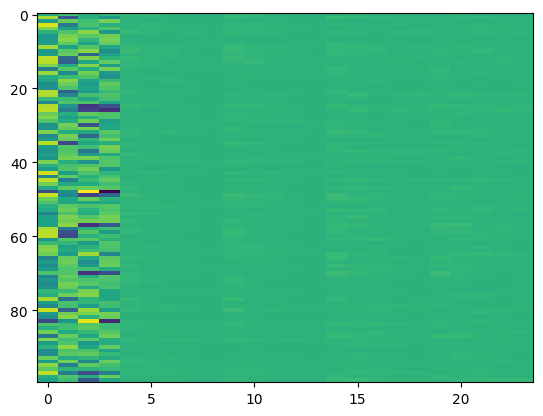

In [153]:
plt.imshow(resampled_data[0:100, :], aspect='auto')

In [149]:
data

array([[-0.78591109,  0.77419049,  0.66025742, ...,  0.05005602,
         0.05202988,  0.07728016],
       [-0.78346177,  0.71563193,  0.7156856 , ...,  0.05192761,
         0.05344984,  0.0833626 ],
       [-0.78312051,  0.65880944,  0.7370211 , ...,  0.05383175,
         0.05460086,  0.08785459],
       ...,
       [-0.80121925,  0.58909896, -0.19469484, ...,  0.00384156,
         0.00981789,  0.00748398],
       [-0.80010451,  0.58982429, -0.19166517, ...,  0.0038373 ,
         0.00985215,  0.00818913],
       [-0.79949365,  0.59012844, -0.19842836, ...,  0.00387049,
         0.0098801 ,  0.00864171]], shape=(145035, 24))

In [148]:
concatenated_subsampled

array([[ 7.83926449e-01,  1.48894879e-01,  2.78195525e-01, ...,
         3.44389030e-04,  1.73692386e-04,  4.77586972e-04],
       [ 8.73196639e-01, -5.71775477e-01,  3.45172226e-01, ...,
         2.70405539e-02,  4.03024048e-03,  3.07561592e-04],
       [ 7.86685371e-01, -4.54874991e-01,  8.33489757e-01, ...,
         1.52436624e-03,  2.50570218e-04,  5.07220416e-04],
       ...,
       [ 1.35452550e+00, -1.48872044e+00, -2.37602573e-01, ...,
         1.00767364e-02,  6.30082430e-02,  5.25422137e-03],
       [-7.91439042e-01,  5.86373294e-01,  1.20375598e-01, ...,
         3.94836899e-02,  7.02475241e-02,  4.66777943e-02],
       [ 1.46537884e+00, -1.15988365e+00,  5.95543503e-01, ...,
         4.08375782e-02,  4.74337049e-02,  4.76002117e-02]],
      shape=(136000, 24))

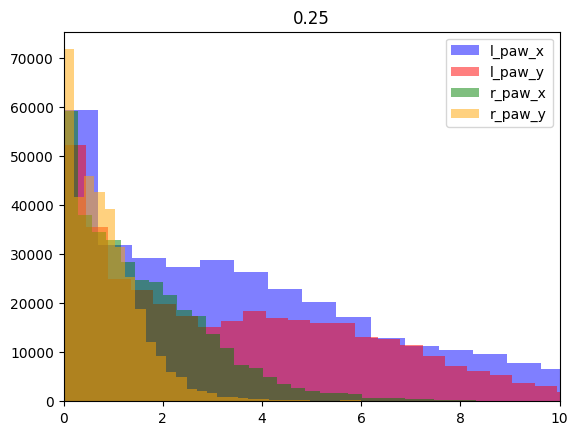

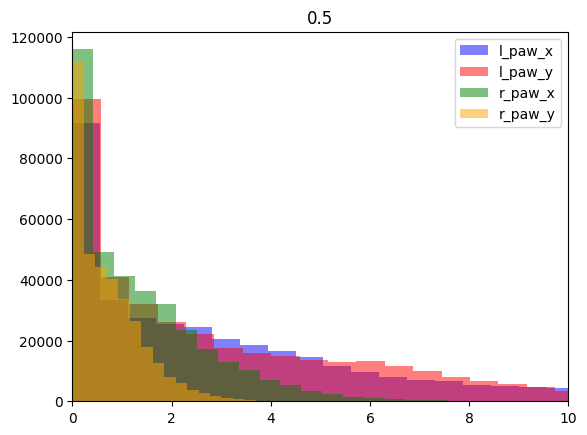

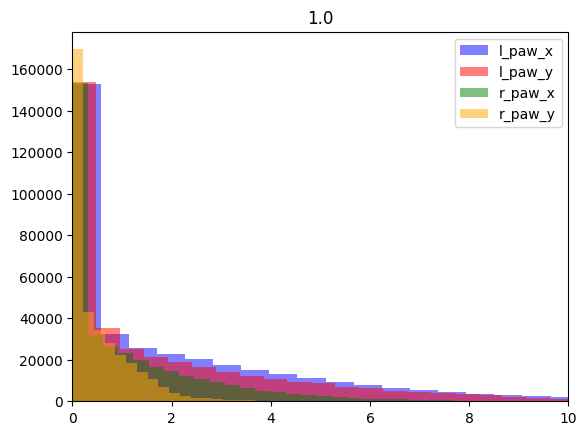

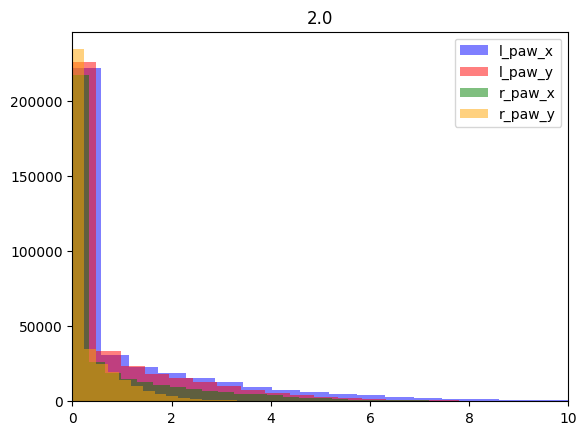

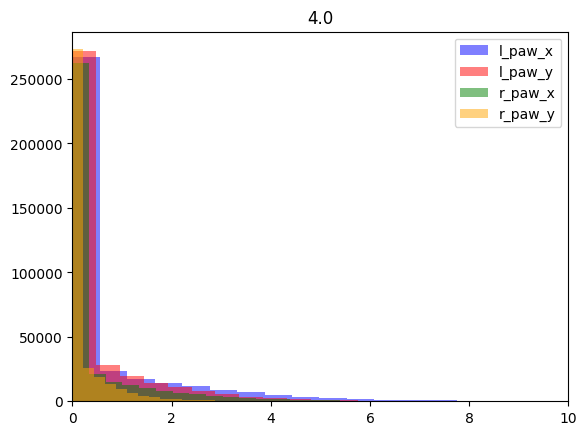

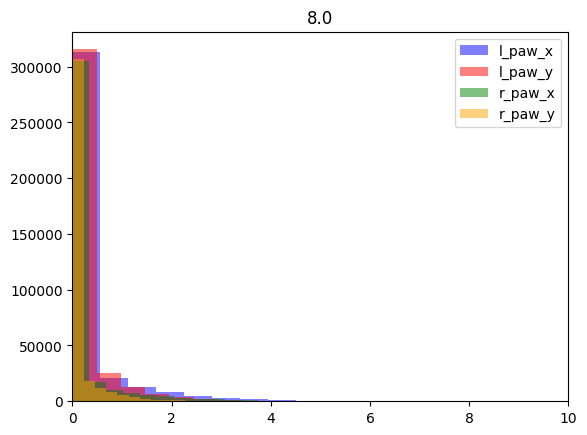

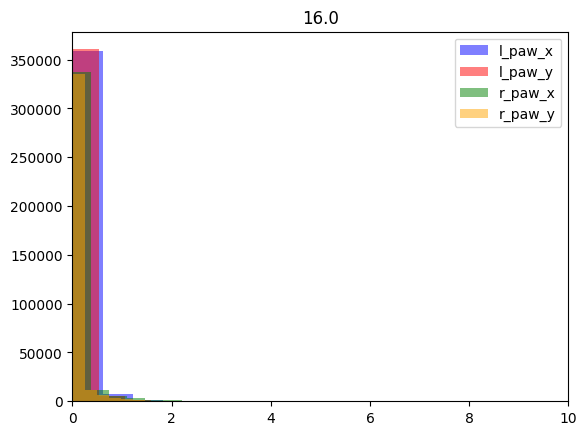

In [52]:
for i, frequency in enumerate(f):
    for v, var in enumerate(var_interest):
        plt.hist(design_matrix[str(var+str(frequency))], 
                alpha=.5, color=colors[v], label=var, bins=50)
        plt.legend()
    plt.xlim([0, 10])
    plt.title(frequency)
    plt.show()

## Save data

In [65]:
assert concatenated_subsampled.shape[0] == 2000 * len(sessions_to_process)

In [134]:
np.save(open('supersession_wavelets08-20-2025', 'wb'), concatenated_subsampled)

In [141]:
file_to_save = concatenated_subsampled.copy()
filename = 'supersession_wavelets_paw'
save_path = prefix + '/representation_learning_variability/Models/Sub-trial/2_fit_models/Wavelets/'
file_format = 'npy'
script_name = 'importance_sampling.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)